In [ ]:
!wget https://ascend-hql.obs.cn-north-4.myhuaweicloud.com/newMushrooms.zip

In [22]:
# 删除损坏的数据
import os
bad_data = os.path.join('Mushrooms','Russula','092_43B354vYxm8.jpg')
if os.path.exists(bad_data):
    os.remove(bad_data)

In [5]:
!pip install split-folders==0.4.3

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple


In [20]:
import splitfolders
splitfolders.ratio('Mushrooms', output="data", seed=1706, ratio=(.8, .0, .2)) # 这里Mushrooms是原始数据文件夹，data是切分后的数据文件夹

Copying files: 6713 files [01:14, 90.10 files/s] 


In [15]:
import mindspore.dataset as ds # 数据集载入
import mindspore.nn as nn # 各类网络层都在nn里面
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor # 回调函数
from mindspore.train import Model # 承载网络结构
from mindspore import load_checkpoint # 读取最佳参数
from mindspore import context # 设置mindspore运行的环境

from easydict import EasyDict as ed # 超参数保存
import numpy as np # numpy
import matplotlib.pyplot as plt # 可视化

# 文件处理相关
import os

# 华为云文件传输相关
import moxing

In [23]:
device_target = context.get_context('device_target') # 获取运行装置（CPU，GPU，Ascend）
dataset_sink_mode = True if device_target in ['Ascend','GPU'] else False # 是否将数据通过pipeline下发到装置上
context.set_context(mode = context.GRAPH_MODE, device_target = device_target) # 设置运行环境，静态图context.GRAPH_MODE指向静态图模型，即在运行之前会把全部图建立编译完毕

print(f'device_target: {device_target}')
print(f'dataset_sink_mode: {dataset_sink_mode}')

device_target: Ascend
dataset_sink_mode: True


In [24]:
# 数据路径
train_path = os.path.join('data', 'train')
test_path = os.path.join('data', 'test')

# 超参数
config = ed({
    # 训练参数
    'batch_size': 32,
    'epochs': 150,
    
    #网络参数
    'class_num': 9,

    # 动态学习率调节
    'warmup_epochs': 5,
    'lr_init': 0.01,
    'lr_max': 0.1,

    # 优化器参数
    'momentum': 0.9,
    'weight_decay': 4e-5})

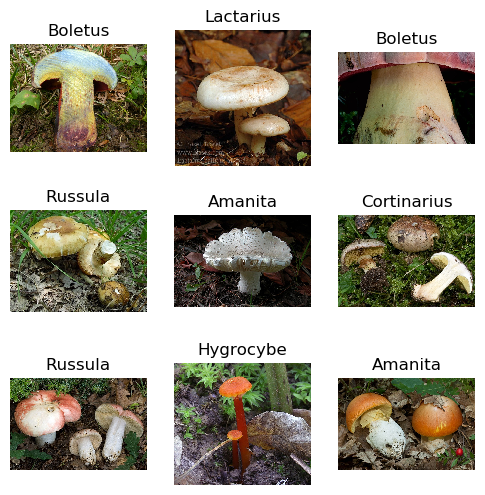

In [25]:
# 创建图像标签列表
category_dict = {0:'Agaricus',1:'Amanita',2:'Boletus',3:'Cortinarius',4:'Entoloma',
                 5:'Hygrocybe',6:'Lactarius',7:'Russula',8:'Suillus'}

# 载入展示用数据
demo_ds = ds.ImageFolderDataset(test_path, decode=True)

# 设置图像大小
plt.figure(figsize=(6, 6))

# 打印9张子图
i = 1
for dic in demo_ds.create_dict_iterator():
    plt.subplot(3,3,i)
    plt.imshow(dic['image'].asnumpy()) # asnumpy：将 MindSpore tensor 转换成 numpy
    plt.axis('off')
    plt.title(category_dict[dic['label'].asnumpy().item()])
    i +=1
    if i > 9 :
        break

plt.show()

In [26]:
train_ds = ds.ImageFolderDataset(train_path, decode=True)
#计算数据集平均数和标准差，数据标准化时使用
tmp = np.asarray( [np.mean(x['image'], axis=(0, 1)) for x in train_ds.create_dict_iterator(output_numpy=True)] )
RGB_mean = tuple(np.mean(tmp, axis=(0)))
RGB_std = tuple(np.std(tmp, axis=(0)))

print(RGB_mean)
print(RGB_std)

RuntimeError: Unexpected error. Invalid data, failed to decode image: data/train/Russula/092_43B354vYxm8.jpg
Line of code : 95
File         : /home/jenkins/agent-working-dir/workspace/Compile_Ascend_ARM_CentOS@2/mindspore/mindspore/ccsrc/minddata/dataset/engine/datasetops/source/image_folder_op.cc


In [ ]:
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
import mindspore.common.dtype as mstype
import mindspore.dataset as ds

def create_dataset(data_path, mean=None, std=None, repeat_num=1, batch_size=32, usage='train'):
    """
    数据处理

    Args:
        dataset_path (str): 数据路径
        repeat_num (int): 数据重复次数
        batch_size (int): 批量大小
        usage (str): 训练或测试

    Returns:
        Dataset对象
    """

    # 载入数据集
    if usage=='train':
        data = ds.ImageFolderDataset(data_path)
    else:
        # 每类取63个样本（最小类样本总数）
        sample_num = 63
        data = ds.ImageFolderDataset(data_path, sampler=ds.PKSampler(sample_num))

    # 打乱数据集
    data = data.shuffle(buffer_size=10000)

    # 设定resize和normalize参数
    image_size = 224
    rgb_mean = mean
    rgb_std = std

    # 定义算子
    if usage=='train':
        trans = [
            CV.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            CV.RandomHorizontalFlip(prob=0.5),
            CV.Normalize(mean=mean, std=std),
            CV.HWC2CHW()
        ]
    else:
        trans = [
            CV.Decode(),
            CV.Resize(256),
            CV.CenterCrop(image_size),
            CV.Normalize(mean=mean, std=std),
            CV.HWC2CHW()
        ]

    type_cast_op = C.TypeCast(mstype.int32)


    # 算子运算
    data = data.map(operations=trans, input_columns="image")
    data = data.map(operations=type_cast_op, input_columns="label")


    # 批处理
    if usage == 'train':
        drop_remainder = True
    else:
        drop_remainder = False
        
    data = data.batch(batch_size, drop_remainder=drop_remainder)

    # 重复
    data = data.repeat(repeat_num)

    return data

In [ ]:
from preprocess import create_dataset

In [ ]:
# 这里将网络分为backbone和head，backbone是ResNet包含残差块的部分，head是最后的全连接层。
from network import resnet50_backbone, resnet50_head

# 最终网络由backbone和head组成。
class ResNet50(nn.Cell):
    """
    ResNet architecture.

    Args:
        backbone (Cell): ResNet50 backbone网络
        head (Cell): ResNet50 head网络
    Returns:
        Tensor, 输出张量

    Examples:
        >>> ResNet50(resnet_backbone,
        >>>          resnet_head)
    """

    def __init__(self, backbone, head):
        super(ResNet50, self).__init__()

        self.backbone = backbone
        self.head = head

    def construct(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [ ]:
# 训练集
train_data = create_dataset(data_path=train_path, 
                            mean=RGB_mean, 
                            std=RGB_std, 
                            batch_size=config.batch_size, 
                            usage='train',
                            repeat_num=1)

# 测试集
test_data = create_dataset(data_path=test_path, 
                            mean=RGB_mean, 
                            std=RGB_std, 
                            batch_size=config.batch_size, 
                            usage='test',
                            repeat_num=1)

In [ ]:
import numpy as np

def get_lr(total_epochs,
           steps_per_epoch,
           lr_init=0.01,
           lr_max=0.1,
           warmup_epochs=5):
    """
    生成学习率数组
    
    Args:
        total_epochs (int): 总epoch数
        steps_per_epoch (float): 每个epoch多少step
        lr_init (float): 初始学习率
        lr_max (float): 最大学习率
        warmup_epochs (int): 预热epoch数

    Returns:
        numpy.ndarray，学习率数组
    """

    lr_each_step = [] # 学习率数组（回传）
    total_steps = steps_per_epoch * total_epochs # 总step数
    warmup_steps = steps_per_epoch * warmup_epochs # 预热step数

    # 计算预热阶段学习率递增值
    if warmup_steps != 0:
        inc_each_step = (float(lr_max) - float(lr_init)) / float(warmup_steps)
    else:
        inc_each_step = 0

    # 学习率调整
    for i in range(int(total_steps)):
        if i < warmup_steps:
        	# 预热（学习率线性递增）
            lr = float(lr_init) + inc_each_step * float(i)
        else:
        	# 衰减（学习率指数递减）
            base = ( 1.0 - (float(i) - float(warmup_steps)) / (float(total_steps) - float(warmup_steps)) )
            lr = float(lr_max) * base * base
            if lr < 0.0:
                lr = 0.0

       	# 记录学习率
        lr_each_step.append(lr)

    lr_each_step = np.array(lr_each_step).astype(np.float32)

    return lr_each_step

In [ ]:
from lr_scheduler import get_lr

# 训练step总数
train_step_size = train_data.get_dataset_size()

# 学习率数组
lr = get_lr(total_epochs=config.epochs, 
            steps_per_epoch=train_step_size,
            lr_init=config.lr_init,
            lr_max=config.lr_max,
            warmup_epochs=config.warmup_epochs)

In [ ]:
# 网络
backbone_net = resnet50_backbone() # backbone网络，保存后能提供后续迁移学习使用
head_net = resnet50_head(config.class_num) # head网络，resnet50最后的全连接层
net = ResNet50(backbone_net, head_net)

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
opt = nn.Momentum(net.trainable_params(), lr, momentum=config.momentum, weight_decay=config.weight_decay)
# 模型
model = Model(net, loss_fn = net_loss,
              optimizer = opt, metrics = {'accuracy','loss'})

In [ ]:
from mindspore.train.callback import Callback
from mindspore import save_checkpoint
import os, stat, copy

# 记录模型accuracy
class TrainHistroy(Callback):
    
    def __init__(self, history):
        super(TrainHistroy, self).__init__()
        self.history = history
        
    # 每个epoch结束时执行
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs.asnumpy()
        self.history.append(loss)
        
        
# 测试并记录模型在测试集的loss和accuracy，每个epoch结束时进行模型测试并记录结果，跟踪并保存准确率最高的模型的网络参数
class EvalHistory(Callback):
    #保存accuracy最高的网络参数
    best_param = None
    best_param_backbone = None
    
    def __init__(self, model, backbone, loss_history, acc_history, eval_data):
        super(EvalHistory, self).__init__()
        self.model = model
        self.backbone = backbone
        self.loss_history = loss_history
        self.acc_history = acc_history
        self.eval_data = eval_data
    
    # 每个epoch结束时执行
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        res = self.model.eval(self.eval_data, dataset_sink_mode=False)
        
        if len(self.acc_history)==0:
            self.best_param = copy.deepcopy(cb_params.network)
            self.best_param_backbone = copy.deepcopy(self.backbone)
        elif res['accuracy']>=max(self.acc_history):
            self.best_param = copy.deepcopy(cb_params.network)
            self.best_param_backbone = copy.deepcopy(self.backbone)

        self.loss_history.append(res['loss'])
        self.acc_history.append(res['accuracy'])
        
        print('acc_eval: ',res['accuracy'])
    
    # 训练结束后执行
    def end(self, run_context):
        # 保存最优网络参数
        if os.path.exists('best_param.ckpt'):
            os.chmod('best_param.ckpt', stat.S_IWRITE)
        if os.path.exists('best_param_backbone.ckpt'):
            os.chmod('best_param_backbone.ckpt', stat.S_IWRITE)
        save_checkpoint(self.best_param, 'best_param.ckpt')
        save_checkpoint(self.best_param_backbone, 'best_param_backbone.ckpt')

In [ ]:
time_cb = TimeMonitor(data_size=train_step_size) # 监控每次迭代的时间
loss_cb = LossMonitor() # 监控loss值
hist = {'loss':[], 'loss_eval':[], 'acc_eval':[]} # 训练过程记录

# 记录每次迭代的模型准确率
train_hist_cb = TrainHistroy(hist['loss'])

# 测试并记录模型在验证集的loss和accuracy，并保存最优网络参数
eval_hist_cb = EvalHistory(model = model,
                           backbone = backbone_net,
                           loss_history = hist['loss_eval'], 
                           acc_history = hist['acc_eval'], 
                           eval_data = test_data)

cb = [time_cb, loss_cb, train_hist_cb, eval_hist_cb]

In [ ]:
model.train(config.epochs, train_data, callbacks=cb)

In [ ]:
# 定义loss记录绘制函数
def plot_loss(hist):
    plt.plot(hist['loss'], marker='.')
    plt.plot(hist['loss_eval'], marker='.')
    plt.title('loss record')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss_train', 'loss_eval'], loc='upper right')
    plt.show()
    plt.close()

plot_loss(hist)

In [ ]:
def plot_accuracy(hist):
    plt.plot(hist['acc_eval'], marker='.')
    plt.title('accuracy history')
    plt.xlabel('epoch')
    plt.ylabel('acc_eval')
    plt.grid()
    plt.show()
    plt.close()

plot_accuracy(hist)

In [ ]:
# 使用准确率最高的参数组合建立模型，并测试其在验证集上的效果
load_checkpoint('best_param.ckpt', net=net)
res = model.eval(test_data, dataset_sink_mode=False)
print(res)

In [ ]:
# 创建图像标签列表
category_dict = {0:'Agaricus',1:'Amanita',2:'Boletus',3:'Cortinarius',4:'Entoloma',
                 5:'Hygrocybe',6:'Lactarius',7:'Russula',8:'Suillus'}

ds_test_demo = create_dataset(test_path, mean=RGB_mean, std=RGB_std, batch_size=1, usage='test')

# 将数据标准化至0~1区间
def normalize(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

In [ ]:
# 设置图像大小
plt.figure(figsize=(10,10))
i = 1
# 打印9张子图
for dic in ds_test_demo.create_dict_iterator():
    # 预测单张图片
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(),axis=1)[0] # 反馈可能性最大的类别
    
    # 可视化
    plt.subplot(3,3,i)
    input_image = np.squeeze(input_img.asnumpy(),axis=0).transpose(1,2,0) # 删除batch维度
    input_image = normalize(input_image) # 重新标准化，方便可视化
    plt.imshow(input_image)
    plt.axis('off')
    plt.title('True: %s\n Predict: %s'%(category_dict[dic['label'].asnumpy().item()],category_dict[predict]))
    i +=1
    if i > 9 :
        break

plt.show()

In [ ]:
# 将ckpt上传到OBS
print('输入目标路径（例：obs://桶名/目录/best_param_backbone.ckpt）')
dst = input('目标路径：')
moxing.file.copy_parallel(src_url='best_param_backbone.ckpt', dst_url=dst)